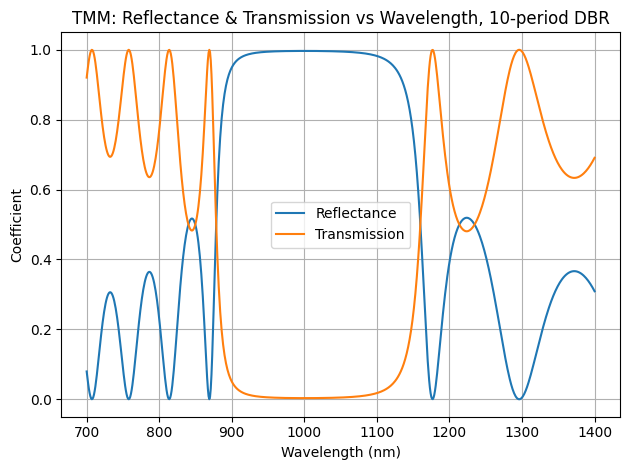

In [19]:
# TMM Reflectance & Transmission vs. Wavelength (10-period DBR)
import numpy as np  # numerical ops
import matplotlib.pyplot as plt  # plotting
from typing import Tuple  # type hints

# DBR specs: layer thickness in nm and refractive indices
D1, D2 = 172.0, 121.0    # low-index & high-index layer thickness
N0, N1, N2 = 1.0, 1.45, 2.07  # air, layer1, layer2 refractive indices\
PERIODS_10 = 10

# Fresnel scattering at an interface: returns 2×2 matrix of amplitudes
def fresnel(k_from: float, k_to: float) -> np.ndarray:
    r = 0.5 * (1 + k_from / k_to)  # reflection amplitude
    t = 0.5 * (1 - k_from / k_to)  # transmission amplitude
    return np.array([[r, t], [t, r]], dtype=complex)

# Phase shift through a uniform layer of thickness d
def propagation(k: float, d: float) -> np.ndarray:
    phi = np.exp(1j * k * d)       # forward wave phase
    return np.diag([phi, 1/phi])    # forward/backward diagonal

# Compute reflectance (R) and transmittance (T) at wavelength wl (nm)
def reflectance_transmission_wl(wl: float) -> Tuple[float, float]:
    # get wavevectors in air, layer1, layer2
    k0, k1, k2 = [2 * np.pi * n / wl for n in (N0, N1, N2)]

    # interface matrices
    M01 = fresnel(k0, k1)  # air → layer1
    M12 = fresnel(k1, k2)  # layer1 → layer2
    M21 = fresnel(k2, k1)  # layer2 → layer1
    M20 = fresnel(k2, k0)  # layer2 → air

    # propagation through each layer
    P1 = propagation(k1, D1)
    P2 = propagation(k2, D2)

    # start with one half-period (air → layer1 → layer2)
    first = P2 @ M12 @ P1 @ M01

    if PERIODS_10 > 1:
        # build full stack by repeating the period
        period = P2 @ M12 @ P1 @ M21
        M = M20 @ (np.linalg.matrix_power(period, PERIODS_10 - 1) @ first)
    else:
        M = M20 @ first

    # extract full transfer matrix elements
    M11, M12_, M21_, M22 = M[0,0], M[0,1], M[1,0], M[1,1]

    # calculate R and T
    R = abs(M21_ / M22)**2
    T = abs((M11 * M22 - M12_ * M21_) / M22)**2
    return R, T

if __name__ == "__main__":
    # wavelength sweep: 700–1400 nm
    wavelengths = np.arange(700, 1401)
    R_vals, T_vals = [], []

    for wl in wavelengths:
        R, T = reflectance_transmission_wl(wl)
        R_vals.append(R)
        T_vals.append(T)

    # plot reflectance & transmission
    plt.figure()
    plt.plot(wavelengths, R_vals, label='Reflectance')
    plt.plot(wavelengths, T_vals, label='Transmission')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Coefficient')
    plt.title('TMM: Reflectance & Transmission vs Wavelength, 10-period DBR')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


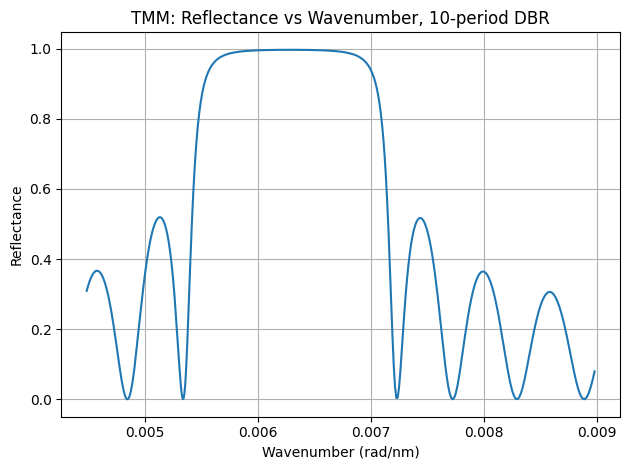

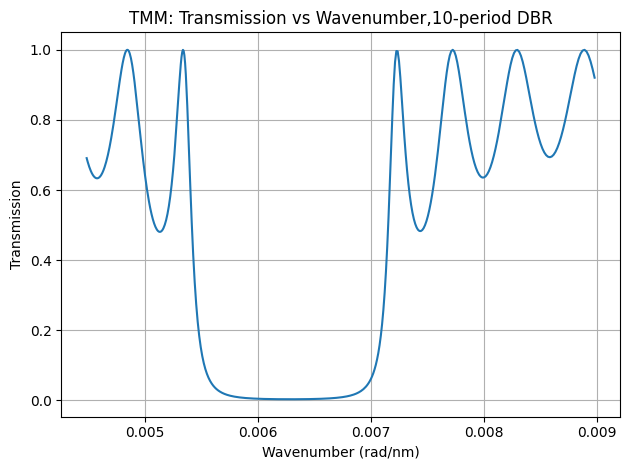

In [18]:
# TMM Reflectance & Transmission vs. Wavenumber (10-period DBR)
import numpy as np  # for math
import matplotlib.pyplot as plt  # for plotting
from typing import Tuple  # for return types

# DBR layer specs
D1, D2 = 172.0, 121.0          # thickness of low/high-index layers (nm)
N0, N1, N2 = 1.0, 1.45, 2.07    # refractive indices: air, layer1, layer2
PERIODS_10 = 10                 # number of layer pairs

# Fresnel matrix at an interface (amplitude r, t)
def fresnel(k_from: float, k_to: float) -> np.ndarray:
    r = 0.5 * (1 + k_from / k_to)  # reflection amp
    t = 0.5 * (1 - k_from / k_to)  # transmission amp
    return np.array([[r, t], [t, r]], dtype=complex)

# Propagation matrix for a layer: phase shift
def propagation(k: float, d: float) -> np.ndarray:
    phi = np.exp(1j * k * d)  # forward wave picks up phase
    return np.diag([phi, 1/phi])  # diag for forward/backward

# Calculate R and T for given wavelength and stack size
def reflectance_transmission_k(wl: float, periods: int) -> Tuple[float, float]:
    # wavevectors in each region: k = 2π n / λ
    k0, k1, k2 = [2 * np.pi * n / wl for n in (N0, N1, N2)]

    # build interface matrices
    M01 = fresnel(k0, k1)  # air → layer1
    M12 = fresnel(k1, k2)  # layer1 → layer2
    M21 = fresnel(k2, k1)  # layer2 → layer1
    M20 = fresnel(k2, k0)  # layer2 → air

    # propagation through layers
    P1 = propagation(k1, D1)
    P2 = propagation(k2, D2)

    # one half-period: go from air into layers
    first = P2 @ M12 @ P1 @ M01

    # repeat full periods then end at air
    if periods > 1:
        period = P2 @ M12 @ P1 @ M21  # full period scattering
        total = M20 @ (np.linalg.matrix_power(period, periods - 1) @ first)
    else:
        total = M20 @ first

    # unpack transfer matrix
    m11, m12, m21, m22 = total[0,0], total[0,1], total[1,0], total[1,1]

    # reflectance and transmittance
    R = abs(m21 / m22)**2
    T = abs((m11 * m22 - m12 * m21) / m22)**2
    return R, T

if __name__ == "__main__":
    # sweep λ from 700 to 1400 nm
    wavelengths = np.linspace(700, 1400, 500)
    R_vals, T_vals = [], []  # store results

    # compute R, T for each λ
    for wl in wavelengths:
        R, T = reflectance_transmission_k(wl, PERIODS_10)
        R_vals.append(R)
        T_vals.append(T)

    # convert λ to free-space wavenumber k0 = 2π / λ
    k0_vals = 2 * np.pi / wavelengths

    # plot reflectance vs k0
    plt.figure()
    plt.plot(k0_vals, R_vals)
    plt.xlabel('Wavenumber (rad/nm)')
    plt.ylabel('Reflectance')
    plt.title('TMM: Reflectance vs Wavenumber, 10-period DBR')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # plot transmission vs k0
    plt.figure()
    plt.plot(k0_vals, T_vals)
    plt.xlabel('Wavenumber (rad/nm)')
    plt.ylabel('Transmission')
    plt.title('TMM: Transmission vs Wavenumber, 10-period DBR')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

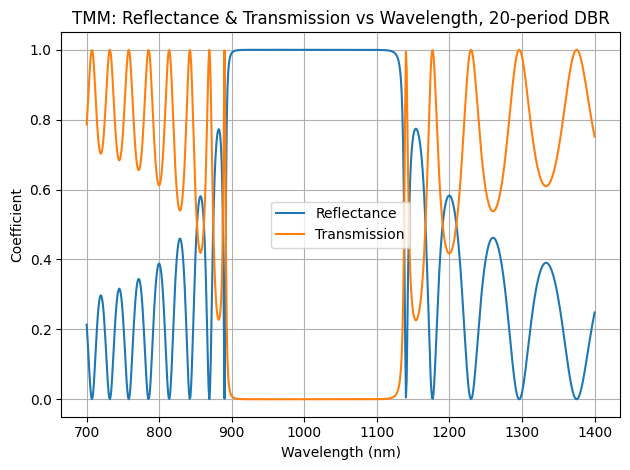

In [20]:
# TMM Reflectance & Transmission vs. Wavelength (20-period DBR)
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# Constants for DBR
D1, D2 = 172.0, 121.0         # thickness of layer 1 and 2 in nm
N0, N1, N2 = 1.0, 1.45, 2.07   # refractive indices: incident medium, layer1, layer2\
PERIODS_20 = 20          # number of layer pairs

# Compute Fresnel coefficients (reflection and transmission) between two media
def fresnel(k_from: float, k_to: float) -> np.ndarray:
    # r and t are amplitude coefficients
    r = 0.5 * (1 + k_from / k_to)
    t = 0.5 * (1 - k_from / k_to)
    # return 2x2 scattering matrix
    return np.array([[r, t], [t, r]], dtype=complex)

# Propagation matrix for a layer of thickness d
def propagation(k: float, d: float) -> np.ndarray:
    # phase shift through the layer
    phi = np.exp(1j * k * d)
    # diagonal matrix: forward and backward waves acquire opposite phase
    return np.diag([phi, 1/phi])

# Compute reflectance R and transmission T at a given wavelength (wl in nm)
def reflectance_transmission_wl(wl: float) -> Tuple[float, float]:
    # convert wavelength to wavevector k = 2πn / λ
    k0, k1, k2 = [2 * np.pi * n / wl for n in (N0, N1, N2)]

    # Fresnel matrices at each interface
    M01 = fresnel(k0, k1)  # between medium 0 and layer 1
    M12 = fresnel(k1, k2)  # between layer 1 and layer 2
    M21 = fresnel(k2, k1)  # between layer 2 and layer 1
    M20 = fresnel(k2, k0)  # between layer 2 and medium 0

    # Propagation through each layer
    P1 = propagation(k1, D1)  # through layer 1
    P2 = propagation(k2, D2)  # through layer 2

    # Build one period: layer1 and layer2
    first = P2 @ M12 @ P1 @ M01

    # If more than one period, repeat the period matrix
    if PERIODS_10 > 1:
        # single period scattering
        period = P2 @ M12 @ P1 @ M21
        # multiply period (n-1) times and then the first interface chain
        M = M20 @ (np.linalg.matrix_power(period, PERIODS_20 - 1) @ first)
    else:
        M = M20 @ first

    # extract matrix elements for final scattering matrix
    M11, M12_, M21_, M22 = M[0,0], M[0,1], M[1,0], M[1,1]

    # compute reflectance and transmittance
    R = abs(M21_ / M22)**2
    T = abs((M11 * M22 - M12_ * M21_) / M22)**2
    return R, T

if __name__ == "__main__":
    # define wavelength range from 700 to 1400 nm
    wavelengths = np.arange(700, 1401)
    R_vals, T_vals = [], []  # to store results

    # compute R and T for each wavelength
    for wl in wavelengths:
        R, T = reflectance_transmission_wl(wl)
        R_vals.append(R)
        T_vals.append(T)

    # plot the results
    plt.figure()
    plt.plot(wavelengths, R_vals, label='Reflectance')  # reflectance curve
    plt.plot(wavelengths, T_vals, label='Transmission')  # transmission curve
    plt.xlabel('Wavelength (nm)')  # x-axis label
    plt.ylabel('Coefficient')      # y-axis label (R or T)
    plt.title('TMM: Reflectance & Transmission vs Wavelength, 20-period DBR')  # plot title
    plt.legend()    # show legend
    plt.grid(True)  # enable grid
    plt.tight_layout()  # adjust layout
    plt.show()  # display plot


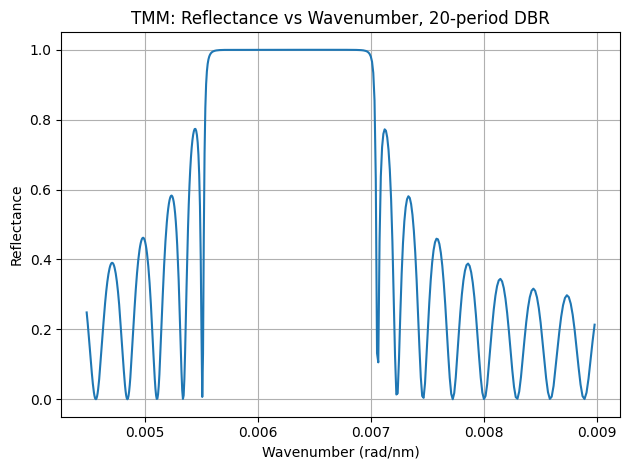

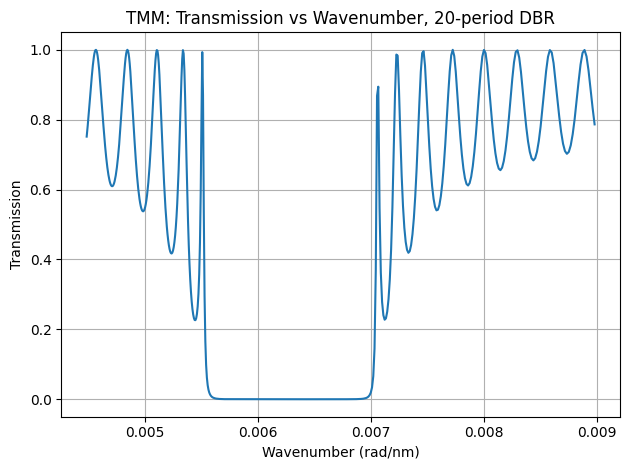

In [22]:
# TMM Reflectance & Transmission vs. Wavenumber (20-period DBR)
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# --- Constants for DBR stack ---
D1, D2 = 172.0, 121.0               # thickness of layer 1 and 2 in nm
N0, N1, N2 = 1.0, 1.45, 2.07         # refractive indices: incident medium, layer1, layer2
PERIODS_20 = 20                      # number of layer pairs to stack

# Reuse Fresnel and propagation functions from previous code

def fresnel(k_from: float, k_to: float) -> np.ndarray:
    # amplitude coefficients for reflection (r) and transmission (t)
    r = 0.5 * (1 + k_from / k_to)
    t = 0.5 * (1 - k_from / k_to)
    return np.array([[r, t], [t, r]], dtype=complex)


def propagation(k: float, d: float) -> np.ndarray:
    # phase shift matrix for forward/backward waves in a layer of thickness d
    phi = np.exp(1j * k * d)
    return np.diag([phi, 1/phi])

# Compute reflectance R and transmission T at wavelength wl (nm) for given number of periods
def reflectance_transmission_k(wl: float, periods: int) -> Tuple[float, float]:
    # convert wavelength to wavevectors in each medium: k = 2πn / λ
    k0, k1, k2 = [2 * np.pi * n / wl for n in (N0, N1, N2)]

    # interface matrices between mediums
    M01 = fresnel(k0, k1)  # air to layer1
    M12 = fresnel(k1, k2)  # layer1 to layer2
    M21 = fresnel(k2, k1)  # layer2 to layer1
    M20 = fresnel(k2, k0)  # layer2 to air

    # propagation through individual layers
    P1 = propagation(k1, D1)  # through layer1
    P2 = propagation(k2, D2)  # through layer2

    # initial period chain: layer1 -> layer2, including first interface
    first = P2 @ M12 @ P1 @ M01

    # build full stack: repeat period (n-1) times, then apply final interface back to air
    if periods > 1:
        period = P2 @ M12 @ P1 @ M21  # scattering for one full period
        # raise to (periods-1) power and prepend the first segment
        M_total = M20 @ (np.linalg.matrix_power(period, periods - 1) @ first)
    else:
        M_total = M20 @ first

    # unpack total scattering matrix elements
    M11, M12_, M21_, M22 = M_total[0,0], M_total[0,1], M_total[1,0], M_total[1,1]

    # calculate reflectance and transmission coefficients
    R = abs(M21_ / M22)**2
    T = abs((M11 * M22 - M12_ * M21_) / M22)**2
    return R, T

if __name__ == "__main__":
    # define wavelength sweep from 700 to 1400 nm with 500 points
    wavelengths = np.linspace(700, 1400, 500)
    R_vals, T_vals = [], []  # store results

    # compute R and T for each wavelength in the stack
    for wl in wavelengths:
        R, T = reflectance_transmission_k(wl, PERIODS_20)
        R_vals.append(R)
        T_vals.append(T)

    # convert wavelengths to wavenumber k0 = 2π / λ for x-axis
    k0_vals = 2 * np.pi / wavelengths

    # plot Reflectance vs Wavenumber
    plt.figure()
    plt.plot(k0_vals, R_vals)              # reflectance curve
    plt.xlabel('Wavenumber (rad/nm)')      # x-axis label
    plt.ylabel('Reflectance')              # y-axis label
    plt.title('TMM: Reflectance vs Wavenumber, 20-period DBR')  # plot title
    plt.grid(True)                         # show grid
    plt.tight_layout()
    plt.show()                             # display

    # plot Transmission vs Wavenumber
    plt.figure()
    plt.plot(k0_vals, T_vals)              # transmission curve
    plt.xlabel('Wavenumber (rad/nm)')      # x-axis label
    plt.ylabel('Transmission')              # y-axis label
    plt.title('TMM: Transmission vs Wavenumber, 20-period DBR')  # plot title
    plt.grid(True)                         # show grid
    plt.tight_layout()
    plt.show()                             # display
